# 數值型資料的離群值偵測方法

本教學將示範如何使用 Z 分數法 (Z-Score)、IQR 法與 DBSCAN 分群法來偵測資料集中的離群值。

我們將會：
- 匯入所需的程式庫
- 建立並視覺化範例資料集
- 使用 Z 分數法偵測離群值
- 使用 IQR 法偵測離群值
- 使用 DBSCAN 分群法偵測離群值
- 比較各種離群值偵測方法

**參考資料：**

- [scikit-learn DBSCAN 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

---

## 1. 匯入所需程式庫

我們將匯入 NumPy、pandas、matplotlib 及 scikit-learn 這些常用的資料處理、視覺化與分群分析套件。

In [1]:
# 匯入所需程式庫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

## 2. 建立並視覺化範例資料集

我們將建立一個 pandas DataFrame，包含發票編號與金額，作為離群值偵測的範例資料。

In [2]:
# 建立範例資料集
data = {
    'Invoice ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'Amount': [185, 188, 192, 191, 187, 190, 194, 195, 1, 189, 120, 450, 189, 190, 193, 191, 187, 188, 186, 189]
}

df = pd.DataFrame(data)
df.head()

,Invoice ID,Amount
0,1,185
1,2,188
2,3,192
3,4,191
4,5,187


讓我們先將這些資料點視覺化，方便理解。

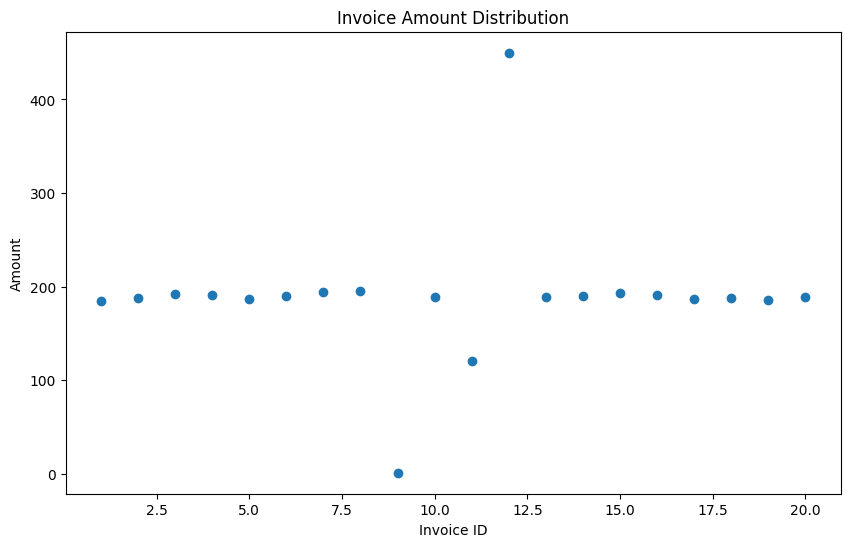

In [3]:
# 繪製散佈圖
plt.figure(figsize=(10, 6))
plt.scatter(df['Invoice ID'], df['Amount'])
plt.title('Invoice Amount Distribution')
plt.xlabel('Invoice ID')
plt.ylabel('Amount')
plt.show()

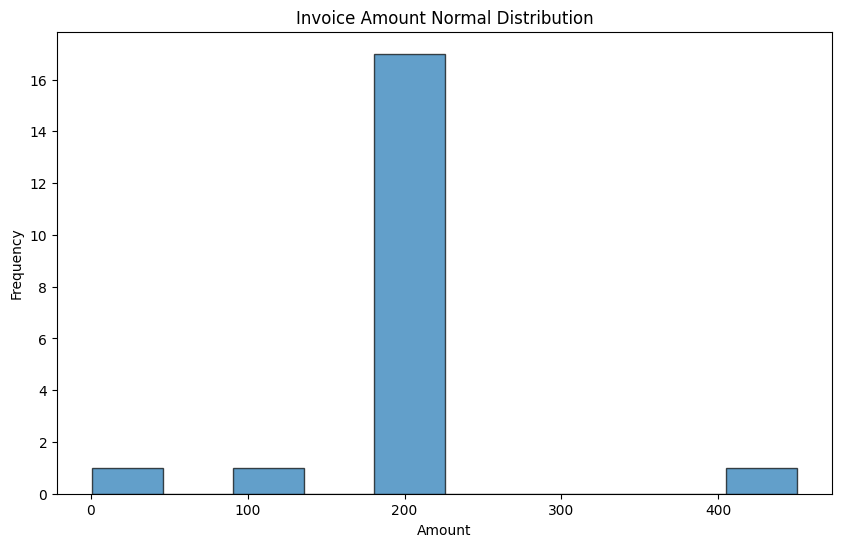

In [4]:
# 繪製常態分佈圖
plt.figure(figsize=(10, 6))
plt.hist(
  df['Amount'],
  bins=10, # 將「Amount」欄位的數值分成10個區間（bin），繪製直方圖
  edgecolor='k',
  alpha=0.7
)
plt.title('Invoice Amount Normal Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

常態分布（Normal Distribution）是一種常見的機率分布，形狀像鐘型（又稱鐘形曲線），大多數數據集中在平均值附近，越遠離平均值的數據越少。它在統計學和資料分析中非常重要，許多自然現象和測量誤差都近似呈現常態分布。

---

## 3. 使用 Z 分數法 (Z-Score) 偵測離群值

* 我們將計算「金額」欄位的平均值與標準差，並計算每個資料點的 Z 分數，根據門檻值判斷是否為離群值。
* Z 分數門檻值常用 ±2 或 ±3 標準差，超過此範圍的值通常被視為離群值。

### 什麼是 Z 分數法 (Z-Score)？

Z 分數法是一種統計方法，用來判斷資料點是否為離群值。它衡量每個資料點距離平均值有幾個標準差。

Z 分數的公式如下：

$$

Z = \frac{x - \mu}{\sigma}

$$

其中：

- $x$：資料點
- $\mu$：資料集的平均值 (mu)
- $\sigma$：資料集的標準差 (sigma)

**適用時機：**

- Z 分數法適用於近似常態分布的資料。
- 常用門檻值為 ±2 或 ±3，超過此範圍即視為離群值。

接下來將 Z 分數法應用於本範例資料。

In [5]:
# 計算平均值與標準差
mean = np.mean(df['Amount'])
std_dev = np.std(df['Amount'])

# 計算每個資料點的 Z-Score
df['Z-Score'] = (df['Amount'] - mean) / std_dev

# 設定離群值門檻
threshold = 2

# 判斷離群值
# Z 分數本身有正有負，代表資料點高於或低於平均值幾個標準差。
# 通常在判斷離群值時，只關心「距離平均值有多遠」，不在意方向，因此會取絕對值。
# 例如，若門檻是 2，則只要 |Z| > 2 就視為離群值。
df['Z-Score Outlier'] = np.abs(df['Z-Score']) > threshold

# 顯示結果
df[['Invoice ID', 'Amount', 'Z-Score', 'Z-Score Outlier']]

,Invoice ID,Amount,Z-Score,Z-Score Outlier
0,1,185,-0.064536,False
1,2,188,-0.023776,False
2,3,192,0.030570,False
3,4,191,0.016983,False
4,5,187,-0.037363,False
5,6,190,0.003397,False
6,7,194,0.057743,False
7,8,195,0.071329,False
8,9,1,-2.564461,True
9,10,189,-0.010190,False


### Z 分數 (Z-Score) 結果解讀

- Z 分數絕對值超過門檻（如 |Z| > 2）即視為離群值。
- 上表中的「Z 分數離群值」欄位會標示 True 表示離群。
- 離群值可能代表錯誤、罕見事件或有趣的異常，需依情境判斷。

讓我們將這些離群值視覺化，方便理解。

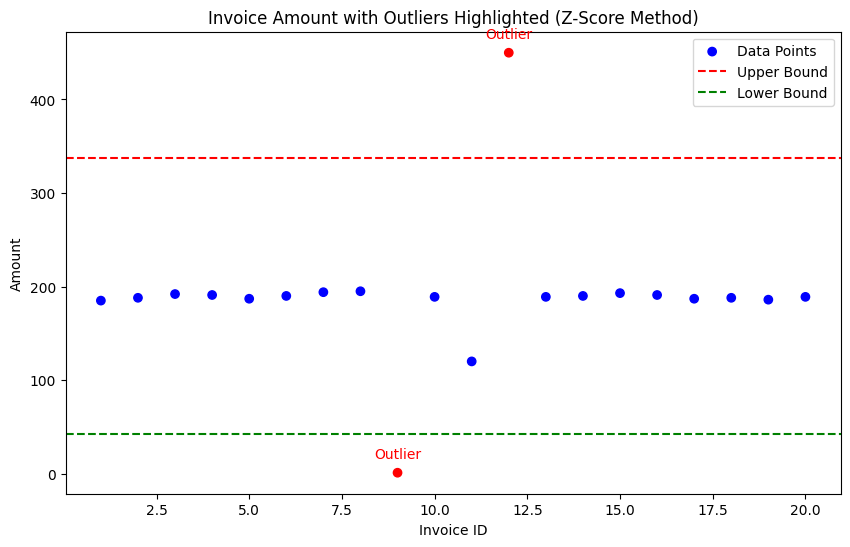

In [6]:
# 繪製 Z 分數離群值散佈圖，標示離群值
plt.figure(figsize=(10, 6))

# 顏色：離群值紅色，正常值藍色
colors = df['Z-Score Outlier'].map({True: 'red', False: 'blue'})

plt.scatter(df['Invoice ID'], df['Amount'], c=colors, label='資料點')
plt.title('Invoice Amount with Outliers Highlighted (Z-Score Method)')
plt.xlabel('Invoice ID')
plt.ylabel('Amount')
plt.axhline(y=mean + threshold * std_dev, color='r', linestyle='--', label='Upper Bound')
plt.axhline(y=mean - threshold * std_dev, color='g', linestyle='--', label='Lower Bound')
plt.legend(['Data Points', 'Upper Bound', 'Lower Bound'])

# 標註離群值
for i, row in df[df['Z-Score Outlier']].iterrows():
    plt.annotate('Outlier', (row['Invoice ID'], row['Amount']), textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.show()

---

## 4. 使用 IQR 法偵測離群值

我們將計算第一四分位數（Q1）與第三四分位數（Q3），再計算 IQR，並根據上下界判斷離群值。

### 什麼是 IQR 法？

IQR（四分位距）法是一種穩健的離群值偵測方法，只考慮資料的中間 50%（介於第 25 百分位 Q1 和第 75 百分位 Q3 之間），不會被極大值或極小值拉動，因此對偏態（skewed）或有離群值的資料特別穩健。

IQR 法的步驟如下：
- **Q1（第 25 百分位）：** 25% 資料點以下的值
- **Q3（第 75 百分位）：** 75% 資料點以下的值
- **IQR：** Q3 - Q1，公式：$$ IQR = Q3 - Q1 $$
- **離群值界限：**
    - 下界：$$ Q1 - 1.5 \times IQR $$
    - 上界：$$ Q3 + 1.5 \times IQR $$
- 超過此範圍的資料點即視為離群值。

**適用時機：**

- IQR 法不要求資料必須符合常態分布，適用於偏態分布(skewed)、長尾分布等各種型態的資料。
- 當資料分布不對稱時，平均值和標準差（如 Z 分數法）可能無法正確反映資料特性，而 IQR 只依賴分位數，更能準確找出異常點。

接下來將 IQR 法應用於本範例資料。

In [7]:
# 計算 Q1（第 25 百分位）與 Q3（第 75 百分位）
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)

# 計算 IQR
IQR = Q3 - Q1

# 設定下界與上界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 判斷離群值
df['IQR Outlier'] = (df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)

# 顯示結果
df[['Invoice ID', 'Amount', 'IQR Outlier']]

,Invoice ID,Amount,IQR Outlier
0,1,185,False
1,2,188,False
2,3,192,False
3,4,191,False
4,5,187,False
5,6,190,False
6,7,194,False
7,8,195,False
8,9,1,True
9,10,189,False


### IQR 結果解讀

- 超過上下界的資料點會在「IQR 離群值」欄位標示為 True。
- 這些離群值可能代表罕見事件、錯誤或有趣的異常。

讓我們將 IQR 離群值視覺化，方便理解。

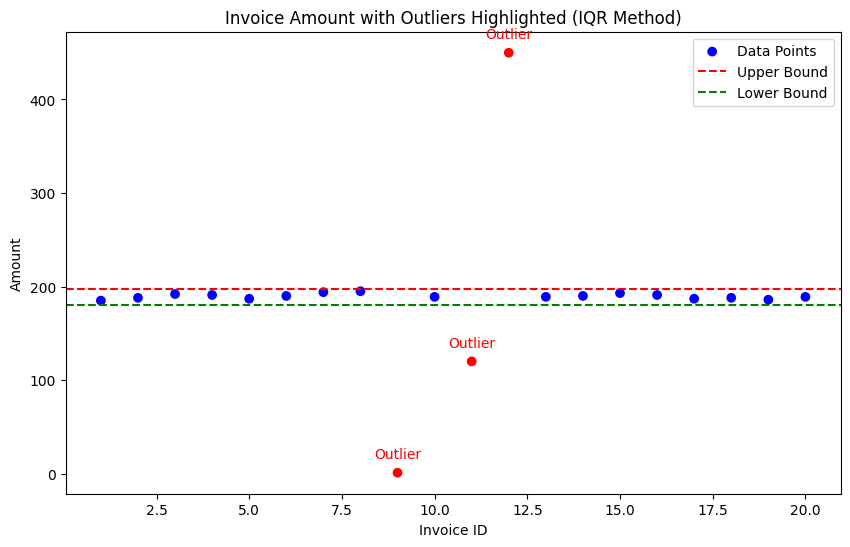

In [8]:
# 繪製 IQR 離群值散佈圖，標示離群值
plt.figure(figsize=(10, 6))

# 顏色：離群值紅色，正常值藍色
colors = df['IQR Outlier'].map({True: 'red', False: 'blue'})

plt.scatter(df['Invoice ID'], df['Amount'], c=colors, label='資料點')
plt.title('Invoice Amount with Outliers Highlighted (IQR Method)')
plt.xlabel('Invoice ID')
plt.ylabel('Amount')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')
plt.axhline(y=lower_bound, color='g', linestyle='--', label='Lower Bound')
plt.legend(['Data Points', 'Upper Bound', 'Lower Bound'])

# 標註離群值
for i, row in df[df['IQR Outlier']].iterrows():
    plt.annotate('Outlier', (row['Invoice ID'], row['Amount']), textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.show()

---

## 5. 使用 DBSCAN 分群法偵測離群值

我們將對「金額」資料套用 DBSCAN 分群演算法，並根據分群結果（標記為 -1 的點）判斷離群值。

### 什麼是 DBSCAN 分群法？

DBSCAN（基於密度的空間分群法）是一種分群演算法，能將密集區域的資料點分群，並將低密度區域的點標記為離群（噪音）。

- **主要參數：**

    - `eps`：兩點被視為鄰居的最大距離。(epsilon)
    - `min_samples`：一個點成為核心點 (core point) 所需的最小鄰居數。

- **運作方式：**

    - 密集區域的點會形成群集。
    - 不屬於任何群集（標記為 -1）的點即為離群值。

**適用時機：**

- DBSCAN 適合有群集且可能有噪音的資料，不需假設分布型態。
- 能偵測任意形狀的群集，且對噪音具備魯棒性。

接下來將 DBSCAN 應用於本範例資料。

In [9]:
# 將「金額」欄位轉為二維陣列
X = df['Amount'].values.reshape(-1, 1)

# 套用 DBSCAN
dbscan = DBSCAN(
  eps=10, # 兩個點被視為鄰居的最大距離
  min_samples=3 # 一個群集至少需要的樣本數量
)
dbscan.fit(X)

# 將 DBSCAN 標籤加入 DataFrame
df['DBSCAN_Label'] = dbscan.labels_

# 判斷離群值（DBSCAN 標記為 -1）
df['DBSCAN Outlier'] = df['DBSCAN_Label'] == -1

# 顯示結果
df[['Invoice ID', 'Amount', 'DBSCAN_Label', 'DBSCAN Outlier']]

,Invoice ID,Amount,DBSCAN_Label,DBSCAN Outlier
0,1,185,0,False
1,2,188,0,False
2,3,192,0,False
3,4,191,0,False
4,5,187,0,False
5,6,190,0,False
6,7,194,0,False
7,8,195,0,False
8,9,1,-1,True
9,10,189,0,False


### DBSCAN 結果解讀

- 被 DBSCAN 標記為 -1 的點即為離群值（噪音）。
- 上表中的「DBSCAN 離群值」欄位會標示 True 表示離群。
- DBSCAN 特別適合有群集且含噪音的資料，且不需假設分布型態。

讓我們將 DBSCAN 離群值視覺化，方便理解。

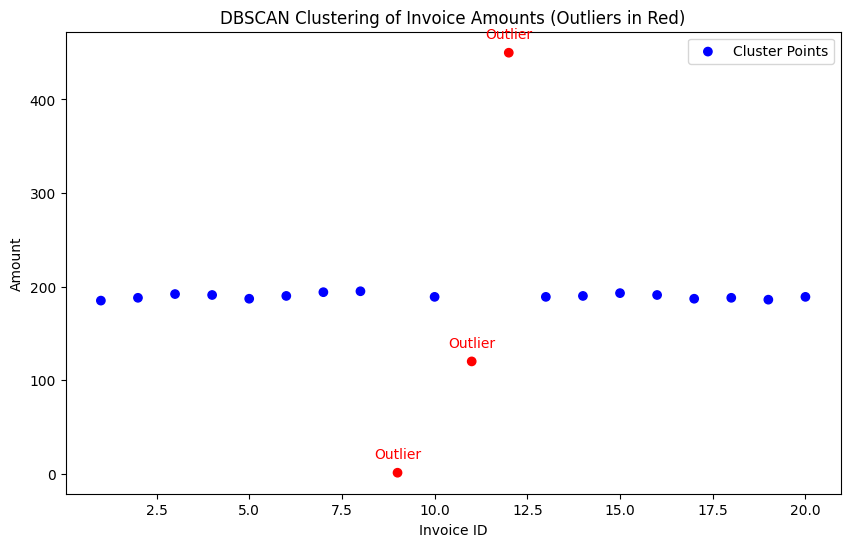

In [10]:
# 繪製 DBSCAN 離群值散佈圖，標示離群值
plt.figure(figsize=(10, 6))

# 顏色：離群值（-1）紅色，群集點藍色
colors = df['DBSCAN_Label'].map(lambda x: 'red' if x == -1 else 'blue')

plt.scatter(df['Invoice ID'], df['Amount'], c=colors, label='群集點')
plt.title('DBSCAN Clustering of Invoice Amounts (Outliers in Red)')
plt.xlabel('Invoice ID')
plt.ylabel('Amount')

# 標註離群值
for i, row in df[df['DBSCAN Outlier']].iterrows():
    plt.annotate('Outlier', (row['Invoice ID'], row['Amount']), textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.legend(['Cluster Points'])
plt.show()

---

## 6. 離群值偵測方法比較

- **Z 分數法：** 適合常態分布資料，對極端值敏感。
- **IQR 法：** 適合偏態或非常態分布資料，對離群值較不敏感。
- **DBSCAN 分群法：** 適合有群集的資料，可偵測噪音與離群值，無需假設分布型態。

**如何選擇方法：**

- 資料呈現對稱、鐘型分布時可用 Z 分數法。
- 資料偏態或非常態分布時可用 IQR 法。
- 資料可能有群集或需偵測噪音時可用 DBSCAN。

在做決策前，務必根據領域知識視覺化並解釋離群值！

**參考資料：**

- [scikit-learn DBSCAN 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)